In [1]:
!pip install guppy3

     |████████████████████████████████| 614kB 7.7MB/s 


## Import modules

In [133]:
import numpy as np

# to get and read data
import os
from scipy.io import loadmat

# to plot the data
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# for clustering
from sklearn.cluster import KMeans

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [134]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/project")
from common_modules import data_f, network_f, patches_f, clusters_f
from char_modules import preprocess_f, plotting_f

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
import importlib
importlib.reload(network_f)

<module 'common_modules.network_f' from '/content/drive/MyDrive/project/common_modules/network_f.py'>

## Get and Read data

get data

In [7]:
data_f.download_file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/character-trajectories/mixoutALL_shifted.mat",
                        saveAs = "mixoutALL_shifted.mat")

#load the file
mat = loadmat('mixoutALL_shifted.mat')
print(mat.keys())

file already exists
dict_keys(['__header__', '__version__', '__globals__', 'consts', 'mixout'])


read data

In [8]:
consts = mat['consts'][0][0]
#print(consts)

classes = [char[0] for char in consts[3][0]]
print(classes)
print('number of classes :',len(classes))

#subtract 1 since np array indexing is from 0
labels = consts[4][0] - 1
inputs = mat['mixout'][0]

train_inputs, test_inputs, train_labels, test_labels = data_f.train_test_split(inputs, labels, test_size=0.25, random_state=0)

train_labels = np.array([int(label) for label in train_labels])
test_labels = np.array([int(label) for label in test_labels])

#append zeroes to resize
train_inputs, target_len = patches_f.append_defaults(train_inputs, 206)
test_inputs, _ = patches_f.append_defaults(test_inputs, 206)

train_data = list(zip(train_inputs, train_labels))
test_data = list(zip(test_inputs, test_labels))

['a', 'b', 'c', 'd', 'e', 'g', 'h', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'y', 'z']
number of classes : 20


max length = 205


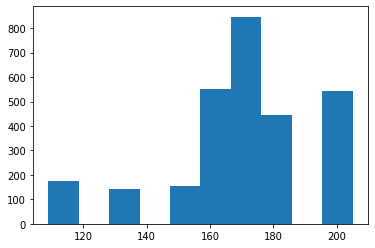

In [ ]:
# distribution of sample lenghts
lengths = []

for sample in inputs:
  input = sample[0]
  input = np.array(input)
  lengths.append(len(input))

print('max length =',np.max(lengths))
_ = plt.hist(lengths)

## Patches

In [9]:
kwargs = {'window_size':20, 'stride':10}

kwargs['data'] = train_data
patch_train_inputs, patch_train_labels, patch_train_indexes = patches_f.dataToPatches(**kwargs)
kwargs['data'] = test_data
patch_test_inputs, patch_test_labels, patch_test_indexes = patches_f.dataToPatches(**kwargs)

### visualize patches

a
original sample


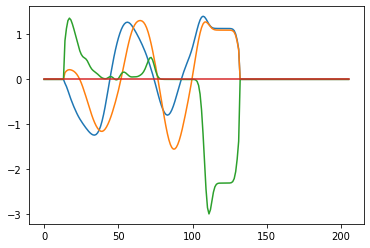

19 patches


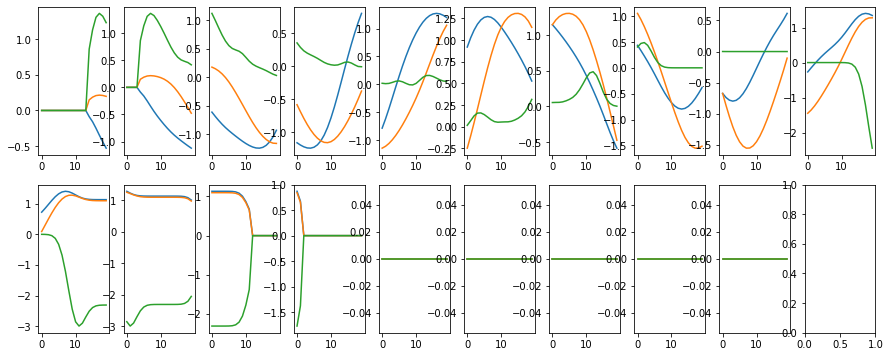

In [ ]:
plotting_f.plotTimeSeries(train_data, patch_train_indexes, patch_train_inputs, char='a', index=0)

a
original sample


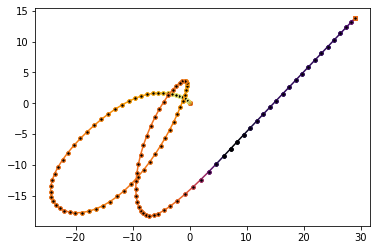

19 patches


/content/drive/MyDrive/project/char_modules/plotting_f.py:19: RuntimeWarning: invalid value encountered in true_divide
  color = (force - np.min(force)) / (np.max(force)-np.min(force))


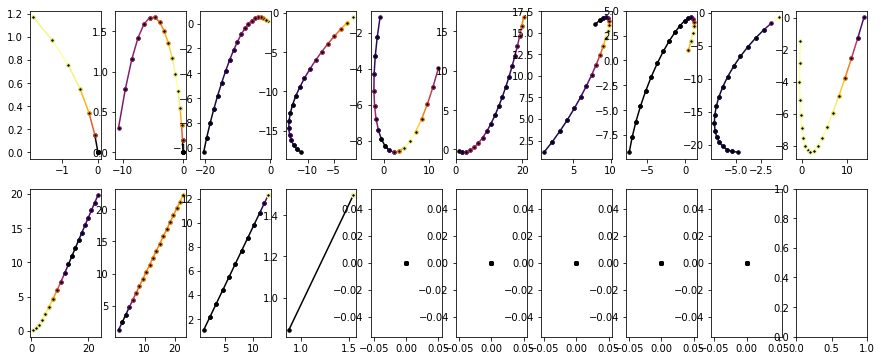

In [ ]:
plotting_f.plotChar(train_data, patch_train_indexes, patch_train_inputs, char='a', index=0)

## Clustering

In [ ]:
# flatten inputs to 2d array
train_inputs2d = clusters_f.flatten_to_2d(train_inputs)

plot silhoutte index for number of cluster 2 and 20

/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "



runtime:  3408.766349554062

memory consumption:
Partition of a set of 920176 objects. Total size = 1110395075 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0   3212   0 996950409  90 996950409  90 numpy.ndarray
     1 238756  26 34132257   3 1031082666  93 str
     2 222729  24 17695184   2 1048777850  94 tuple
     3  92487  10  7324582   1 1056102432  95 bytes
     4  47019   5  6803528   1 1062905960  96 types.CodeType
     5  18253   2  6581120   1 1069487080  96 dict (no owner)
     6  44550   5  6058800   1 1075545880  97 function
     7   5637   1  5498016   0 1081043896  97 type
     8  61098   7  4399056   0 1085442952  98 torch.Tensor
     9   2345   0  3392280   0 1088835232  98 dict of module
<2271 more rows. Type e.g. '_.more' to view.>



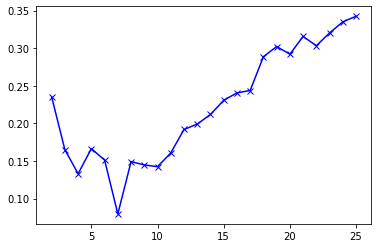

 n_clusters  silhouette      cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
          2    0.235026  3017.100372   2.196952  0.000960     0.010816   0.010956    0.207936
          3    0.164824  2948.814726   2.211393  0.002671     0.020436   0.020688    0.187951
          4    0.132977  2976.645622   2.227971  0.004847     0.023733   0.024076    0.164276
          5    0.166398  2963.983549   2.252780  0.010050     0.035263   0.035690    0.156365
          6    0.151103  2911.027271   2.011092  0.010297     0.043278   0.043788    0.147741
          7    0.079501  2914.426489   2.051750  0.012615     0.046603   0.047188    0.135943
          8    0.149058  2995.438583   1.935959  0.012703     0.045555   0.046211    0.123652
          9    0.144673  2871.602128   1.861532  0.014868     0.057627   0.058364    0.129498
         10    0.142328  2801.416299   1.813801  0.013245     0.045850   0.046654    0.112865
         11    0.160579  2818.421480   1.822056  0.015252   

In [ ]:
_ = clusters_f.form_clusters(train_inputs2d, "KMeans", list(range(2,26)), train_labels)   #list(range(2,31))

### visualize cluster centers


cluster centers visualized


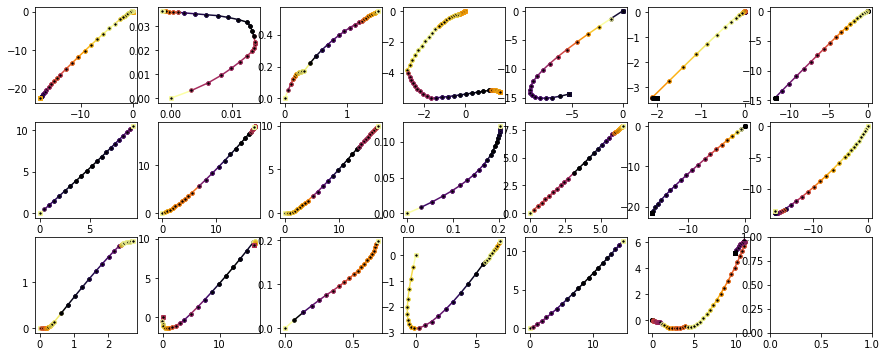

In [ ]:
#kmeans_centers = clusters_f.form_clusters(train_inputs2d, "KMeans", [20], train_labels)
kmeans = KMeans(n_clusters=20, random_state=0).fit(train_inputs2d)
kmeans_centers = kmeans.cluster_centers_

print("\ncluster centers visualized")
plotting_f.plotClusters(kmeans_centers, sample_shape)

## Neural Network

### define network

In [10]:
inp_size = 206; c0 = 4;   # c0 = 4 if indicator channel else 3
k_conv = 3; k_pool = 2; c1 = 8; c2 = 16; c3 = 32;

print("initial size  of  sample = %d x %d" % (c0,inp_size))
conv1_outSize = inp_size-(k_conv-1)
print("output  size after conv1 = %d x %d" % (c1,conv1_outSize))
pool1_outSize = np.floor((conv1_outSize-(k_pool-1)-1)/k_pool + 1)
print("output  size after pool1 = %d x %d" % (c1,pool1_outSize))

conv2_outSize = pool1_outSize-(k_conv-1)
print("output  size after conv2 = %d x %d" % (c2,conv2_outSize))
pool2_outSize = np.floor((conv2_outSize-(k_pool-1)-1)/k_pool + 1)
print("output  size after pool2 = %d x %d" % (c2,pool2_outSize))

conv3_outSize = pool2_outSize-(k_conv-1)
print("output  size after conv3 = %d x %d" % (c3,conv3_outSize))
pool3_outSize = np.floor((conv3_outSize-(k_pool-1)-1)/k_pool + 1)
print("output  size after pool3 = %d x %d" % (c3,pool3_outSize))

initial size  of  sample = 4 x 206
output  size after conv1 = 8 x 204
output  size after pool1 = 8 x 102
output  size after conv2 = 16 x 100
output  size after pool2 = 16 x 50
output  size after conv3 = 32 x 48
output  size after pool3 = 32 x 24


In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 8, 3)
        self.conv2 = nn.Conv1d(8, 16, 3)
        self.conv3 = nn.Conv1d(16, 32, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(768, 20)

    def forward(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x

    def latent(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

create dataset and dataloader

In [40]:
train_loader, val_loader, test_loader = data_f.createLoaders(train_inputs, train_labels,
                                                              test_inputs, test_labels,
                                                              batch_size=32)

### create network

In [41]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min')

### train network

epoch: 15, train loss: 0.200, val loss: 0.261
epoch: 30, train loss: 0.051, val loss: 0.171
epoch: 45, train loss: 0.024, val loss: 0.139
epoch: 60, train loss: 0.011, val loss: 0.143
Finished Training


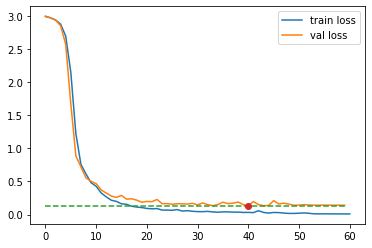

In [42]:
best_params = network_f.trainNet(net,criterion,optimizer, scheduler,
                                  train_loader, val_loader,
                                  epochs=150, earlyStopping=20)

In [43]:
net.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [44]:
print("evaluation results on train data")
network_f.evaluate(net,train_inputs,train_labels,classes)
print("evaluation results on test data")
network_f.evaluate(net,test_inputs,test_labels,classes)

evaluation results on train data



              precision    recall  f1-score   support

           a     1.0000    0.9925    0.9963       134
           b     0.9720    1.0000    0.9858       104
           c     0.9910    1.0000    0.9955       110
           d     0.9919    1.0000    0.9960       123
           e     1.0000    1.0000    1.0000       146
           g     1.0000    1.0000    1.0000        97
           h     0.9362    0.9778    0.9565        90
           l     0.9919    0.9919    0.9919       123
           m     1.0000    0.9885    0.9942        87
           n     0.9479    0.9286    0.9381        98
           o     0.9823    0.9823    0.9823       113
           p     1.0000    0.9895    0.9947        95
           q     1.0000    0.9778    0.9888        90
           r     0.9885    0.9663    0.9773        89
           s     1.0000    1.0000    1.0000        93
           u     0.9811    0.9630    0.9720       108
           v     0.9825    0.9912    0.9868       113
           w     0.9457   


              precision    recall  f1-score   support

           a     0.9737    1.0000    0.9867        37
           b     0.9474    0.9730    0.9600        37
           c     0.9412    1.0000    0.9697        32
           d     1.0000    1.0000    1.0000        34
           e     1.0000    1.0000    1.0000        40
           g     1.0000    0.9756    0.9877        41
           h     0.9722    0.9459    0.9589        37
           l     0.9800    0.9608    0.9703        51
           m     0.9474    0.9474    0.9474        38
           n     0.9000    0.8438    0.8710        32
           o     0.9655    1.0000    0.9825        28
           p     0.9189    0.9444    0.9315        36
           q     0.9444    1.0000    0.9714        34
           r     1.0000    0.8333    0.9091        30
           s     1.0000    1.0000    1.0000        40
           u     0.9200    1.0000    0.9583        23
           v     0.9762    0.9762    0.9762        42
           w     0.9091   

## Latent Representation

### extract and cluster latent representation from the trained network for patches

In [45]:
latent_train_inputs = network_f.netOutput(net, patch_train_inputs, type="latent")
latent_test_inputs = network_f.netOutput(net, patch_test_inputs, type="latent")

# flatten inputs to 2d array
latent_train_inputs2d = clusters_f.flatten_to_2d(latent_train_inputs)
latent_test_inputs2d = clusters_f.flatten_to_2d(latent_test_inputs)

In [46]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(latent_train_inputs2d)
kmeans_train_labels = kmeans.labels_
kmeans_test_labels = kmeans.predict(latent_test_inputs2d)

kmeans_train_labels = np.array([int(label) for label in kmeans_train_labels])
kmeans_test_labels = np.array([int(label) for label in kmeans_test_labels])

create dataset and dataloader

In [47]:
train_loader, val_loader, test_loader = data_f.createLoaders(patch_train_inputs, kmeans_train_labels,
                                                              patch_test_inputs, kmeans_test_labels,
                                                              batch_size=32)

### create network

In [48]:
net2 = Net().to(device)

optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 15, train loss: 0.052, val loss: 0.043
epoch: 30, train loss: 0.041, val loss: 0.035
epoch: 45, train loss: 0.038, val loss: 0.050
epoch: 60, train loss: 0.034, val loss: 0.035
epoch: 75, train loss: 0.034, val loss: 0.026
epoch: 90, train loss: 0.029, val loss: 0.027
Finished Training


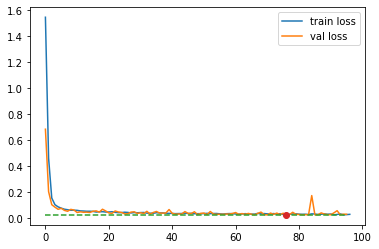

In [49]:
best_params = network_f.trainNet(net2,criterion,optimizer, scheduler, 
                                  train_loader, val_loader,
                                  epochs=150, earlyStopping=20)

In [50]:
net2.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [51]:
print("evaluation results on train data")
network_f.evaluate(net2,patch_train_inputs,kmeans_train_labels)
print("evaluation results on test data")
network_f.evaluate(net2,patch_test_inputs,kmeans_test_labels)

evaluation results on train data



              precision    recall  f1-score   support

           0     0.9904    0.9737    0.9820      2018
           1     0.9933    0.9975    0.9954     17502
           2     0.9874    0.9943    0.9908       870
           3     1.0000    0.9662    0.9828      1390
           4     0.9968    0.9872    0.9920       939
           5     0.9961    0.9832    0.9896      1306
           6     0.9950    0.9871    0.9910      1625
           7     0.9924    0.9775    0.9849       534
           8     0.9936    0.9995    0.9966      2182
           9     0.9723    1.0000    0.9859      1017
          10     0.9718    0.9994    0.9854      1550
          11     0.9990    0.9866    0.9927      2011
          12     0.9989    0.9911    0.9949       894
          13     0.9930    0.9869    0.9899      1147
          14     0.9935    0.9834    0.9884       782
          15     0.9681    0.9961    0.9819       762
          16     0.9896    0.9987    0.9941       759
          17     0.9906   


              precision    recall  f1-score   support

           0     0.9880    0.9735    0.9807       678
           1     0.9934    0.9969    0.9951      5855
           2     0.9696    0.9961    0.9827       256
           3     1.0000    0.9696    0.9845       460
           4     0.9938    0.9728    0.9832       331
           5     0.9955    0.9910    0.9932       442
           6     0.9944    0.9889    0.9917       541
           7     0.9940    0.9824    0.9882       170
           8     0.9920    1.0000    0.9960       740
           9     0.9542    1.0000    0.9765       333
          10     0.9711    1.0000    0.9853       537
          11     0.9985    0.9839    0.9912       683
          12     0.9965    0.9828    0.9896       290
          13     0.9921    0.9843    0.9882       382
          14     0.9907    0.9771    0.9838       218
          15     0.9741    0.9912    0.9826       228
          16     0.9848    1.0000    0.9923       259
          17     0.9887   

# Model based on clusterfit predictions

In [52]:
clustFit_train_inputs = network_f.netOutput(net, patch_train_inputs)
clustFit_test_inputs = network_f.netOutput(net, patch_test_inputs)

In [81]:
# 19 patches for every sample
#print(patch_train_indexes[0:20])

clustFit_train_inputs = patches_f.mergePatches(clustFit_train_inputs,19)
clustFit_test_inputs = patches_f.mergePatches(clustFit_test_inputs,19)

/content/drive/MyDrive/project/common_modules/patches_f.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(merged)


ValueError: ignored

### define network

In [82]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(380, 20)

    def forward(self, x):        
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

create dataset and dataloader

In [83]:
train_loader, val_loader, test_loader = data_f.createLoaders(clustFit_train_inputs, train_labels,
                                                              clustFit_test_inputs, test_labels,
                                                              batch_size=32)

### create network

In [84]:
net3 = Net().to(device)

optimizer = optim.SGD(net3.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 15, train loss: 0.052, val loss: 0.159
epoch: 30, train loss: 0.036, val loss: 0.131
epoch: 45, train loss: 0.019, val loss: 0.150
epoch: 60, train loss: 0.015, val loss: 0.131
Finished Training


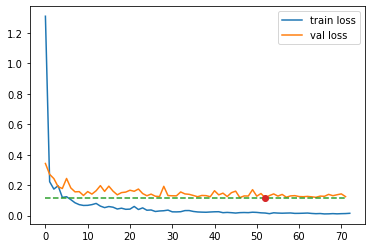

In [85]:
best_params = network_f.trainNet(net3,criterion,optimizer, scheduler, 
                                  train_loader, val_loader,
                                  epochs=150, earlyStopping=20)

In [86]:
net3.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [87]:
print("evaluation results on train data")
network_f.evaluate(net3,clustFit_train_inputs,train_labels)
print("evaluation results on test data")
network_f.evaluate(net3,clustFit_test_inputs,test_labels)

evaluation results on train data



              precision    recall  f1-score   support

           0     1.0000    0.9925    0.9963       134
           1     0.9811    1.0000    0.9905       104
           2     1.0000    1.0000    1.0000       110
           3     1.0000    1.0000    1.0000       123
           4     1.0000    1.0000    1.0000       146
           5     1.0000    1.0000    1.0000        97
           6     0.9565    0.9778    0.9670        90
           7     0.9919    1.0000    0.9960       123
           8     1.0000    0.9885    0.9942        87
           9     0.9691    0.9592    0.9641        98
          10     0.9911    0.9823    0.9867       113
          11     1.0000    1.0000    1.0000        95
          12     1.0000    1.0000    1.0000        90
          13     0.9885    0.9663    0.9773        89
          14     1.0000    1.0000    1.0000        93
          15     0.9907    0.9815    0.9860       108
          16     0.9825    0.9912    0.9868       113
          17     0.9457   


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        37
           1     0.9474    0.9730    0.9600        37
           2     1.0000    1.0000    1.0000        32
           3     1.0000    1.0000    1.0000        34
           4     1.0000    1.0000    1.0000        40
           5     1.0000    0.9756    0.9877        41
           6     0.9730    0.9730    0.9730        37
           7     0.9808    1.0000    0.9903        51
           8     0.9487    0.9737    0.9610        38
           9     0.9643    0.8438    0.9000        32
          10     1.0000    0.9643    0.9818        28
          11     0.9722    0.9722    0.9722        36
          12     0.9429    0.9706    0.9565        34
          13     0.9615    0.8333    0.8929        30
          14     1.0000    1.0000    1.0000        40
          15     0.8846    1.0000    0.9388        23
          16     0.9545    1.0000    0.9767        42
          17     0.9355   

# Fusion model

In [88]:
def fuse(inputs1, inputs2):
  fused = []
  for ip1,ip2 in zip(inputs1,inputs2):
    ip = (ip1,ip2)
    fused.append(ip)
  return fused

In [89]:
fused_train_inputs = fuse(train_inputs, clustFit_train_inputs)
fused_test_inputs = fuse(test_inputs, clustFit_test_inputs)

In [91]:
print(train_inputs.shape)
print(clustFit_train_inputs.shape)

(2143, 4, 206)
(2143, 20, 19)


In [107]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 8, 3)
        self.conv2 = nn.Conv1d(8, 16, 3)
        self.conv3 = nn.Conv1d(16, 32, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1148, 20)

    def forward(self, x):
        x1, x2 = x
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x1)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x2 = x2.view(-1, self.num_flat_features(x2))
        x = torch.cat((x,x2),dim=1)
        x = self.fc1(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

create dataset and dataloader

In [108]:
train_loader, val_loader, test_loader = data_f.createLoaders( fused_train_inputs, train_labels,
                                                              fused_test_inputs, test_labels,
                                                              batch_size=32)

### create network

In [115]:
net4 = Net().to(device)

optimizer = optim.SGD(net4.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 15, train loss: 0.053, val loss: 0.161
epoch: 30, train loss: 0.027, val loss: 0.142
epoch: 45, train loss: 0.020, val loss: 0.137
epoch: 60, train loss: 0.015, val loss: 0.134
Finished Training


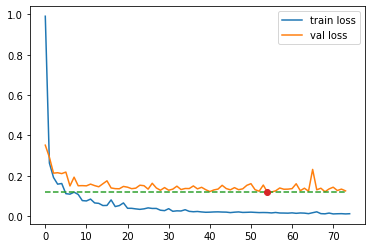

In [116]:
best_params = network_f.trainNet(net4,criterion,optimizer, scheduler, 
                                  train_loader, val_loader,
                                  epochs=150, earlyStopping=20,
                                  approach="fused")

In [117]:
net4.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [137]:
print("evaluation results on train data")
network_f.evaluate(net4,fused_train_inputs,train_labels,approach="fusion")
print("evaluation results on test data")
network_f.evaluate(net4,fused_test_inputs,test_labels,approach="fusion")

evaluation results on train data



              precision    recall  f1-score   support

           0     0.9925    0.9925    0.9925       134
           1     0.9904    0.9904    0.9904       104
           2     1.0000    1.0000    1.0000       110
           3     0.9919    1.0000    0.9960       123
           4     1.0000    1.0000    1.0000       146
           5     1.0000    1.0000    1.0000        97
           6     0.9184    1.0000    0.9574        90
           7     0.9919    1.0000    0.9960       123
           8     1.0000    0.9885    0.9942        87
           9     0.9775    0.8878    0.9305        98
          10     0.9912    0.9912    0.9912       113
          11     0.9896    1.0000    0.9948        95
          12     1.0000    0.9889    0.9944        90
          13     0.9885    0.9663    0.9773        89
          14     1.0000    1.0000    1.0000        93
          15     0.9813    0.9722    0.9767       108
          16     0.9739    0.9912    0.9825       113
          17     0.9565   


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        37
           1     0.9722    0.9459    0.9589        37
           2     0.9412    1.0000    0.9697        32
           3     1.0000    1.0000    1.0000        34
           4     1.0000    1.0000    1.0000        40
           5     1.0000    0.9756    0.9877        41
           6     0.8780    0.9730    0.9231        37
           7     0.9800    0.9608    0.9703        51
           8     0.9487    0.9737    0.9610        38
           9     0.9600    0.7500    0.8421        32
          10     1.0000    1.0000    1.0000        28
          11     0.9722    0.9722    0.9722        36
          12     0.9429    0.9706    0.9565        34
          13     0.9259    0.8333    0.8772        30
          14     1.0000    1.0000    1.0000        40
          15     0.8846    1.0000    0.9388        23
          16     0.9535    0.9762    0.9647        42
          17     0.9355   